In [35]:
# MonteCarloToolkit.ipynb

import sys
import os

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from src.gbm import simulate_gbm_paths, simulate_correlated_gbm_paths

# Ensure figures directory exists (relative to notebook)
figures_dir = os.path.join(parent_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)

plt.style.use("seaborn-v0_8")  # optional

Simulated 10000 GBM paths with 252 steps in 0.085 seconds.


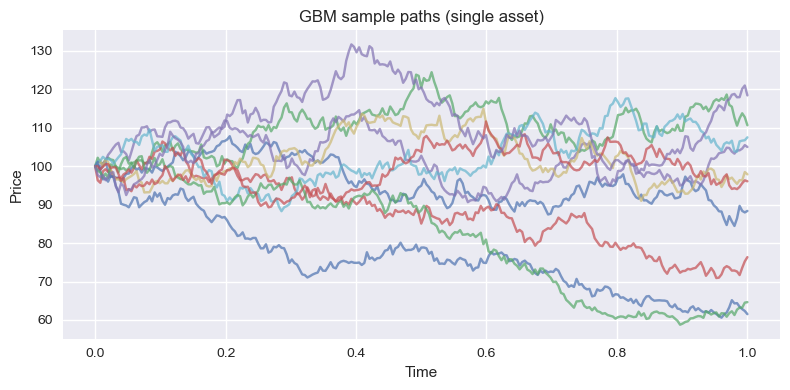

[Single Asset GBM] Empirical mean: 105.315741, Theoretical mean: 105.127110
[Single Asset GBM] Empirical var : 455.772891, Theoretical var : 451.028808
[Single Asset GBM] Rel. error mean: 0.1794%
[Single Asset GBM] Rel. error var : 1.0518%
--------------------------------------------------
Empirical mean: 105.3157, Theoretical mean: 105.1271
Empirical var : 455.7729, Theoretical var : 451.0288
Rel. error mean: 0.1794%
Rel. error var : 1.0518%


In [45]:
# Parameters for "Stock A"
S0 = 100.0
mu = 0.05        # 5% drift
sigma = 0.20     # 20% volatility
T = 1.0          # 1 year
n_steps = 252    # daily
n_paths = 10_000
seed = 42

start = time.perf_counter()
t_grid, paths = simulate_gbm_paths(S0, mu, sigma, T, n_steps, n_paths, seed=seed)
runtime = time.perf_counter() - start

print(f"Simulated {n_paths} GBM paths with {n_steps} steps in {runtime:.3f} seconds.")

# 1) Plot a few sample paths
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.plot(t_grid, paths[i], alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("GBM sample paths (single asset)")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase1_gbm_sample_paths.png"), dpi=150)
plt.show()

# 2) Check empirical mean and variance of S_T against theory
S_T = paths[:, -1]
summary = summarize_terminal_distribution(
    S_T,
    S0=S0,
    mu=mu,
    sigma=sigma,
    T=T,
    label="[Single Asset GBM] "
)


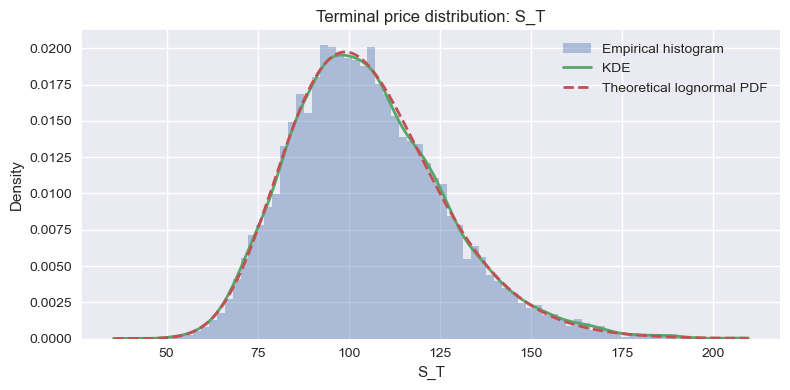

In [11]:
# Terminal price distribution: S_T

plt.figure(figsize=(8, 4))

# Histogram of S_T
count, bins, _ = plt.hist(S_T, bins=80, density=True, alpha=0.4, label="Empirical histogram")

# KDE estimate
kde = gaussian_kde(S_T)
x_vals = np.linspace(S_T.min(), S_T.max(), 500)
plt.plot(x_vals, kde(x_vals), label="KDE", linewidth=2)

# Theoretical lognormal pdf
# If log S_T ~ N(m, v), then m, v:
m = np.log(S0) + (mu - 0.5 * sigma**2) * T
v = sigma**2 * T
lognormal_pdf = (1 / (x_vals * np.sqrt(2 * np.pi * v))) * np.exp(
    -((np.log(x_vals) - m) ** 2) / (2 * v)
)
plt.plot(x_vals, lognormal_pdf, label="Theoretical lognormal PDF", linestyle="--", linewidth=2)

plt.xlabel("S_T")
plt.ylabel("Density")
plt.title("Terminal price distribution: S_T")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase1_gbm_ST_hist_kde_logpdf.png"), dpi=150)
plt.show()


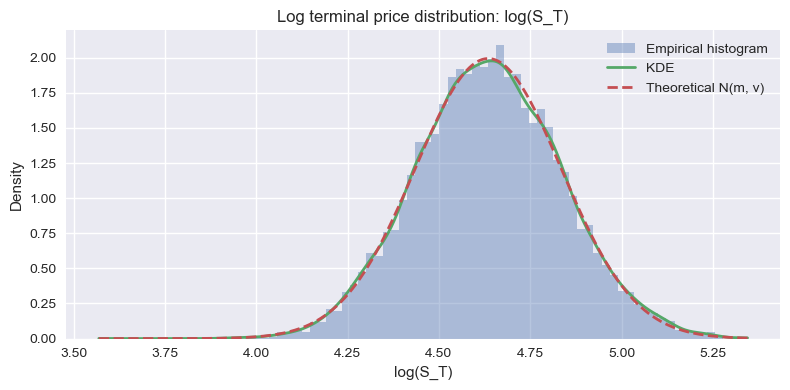

In [13]:
# Log terminal price distribution: log(S_T)

log_S_T = np.log(S_T)

plt.figure(figsize=(8, 4))

# Histogram
plt.hist(log_S_T, bins=80, density=True, alpha=0.4, label="Empirical histogram")

# KDE
kde_log = gaussian_kde(log_S_T)
x_vals_log = np.linspace(log_S_T.min(), log_S_T.max(), 500)
plt.plot(x_vals_log, kde_log(x_vals_log), label="KDE", linewidth=2)

# Theoretical normal pdf with mean m and variance v
normal_pdf = (1 / np.sqrt(2 * np.pi * v)) * np.exp(-(x_vals_log - m) ** 2 / (2 * v))
plt.plot(x_vals_log, normal_pdf, label="Theoretical N(m, v)", linestyle="--", linewidth=2)

plt.xlabel("log(S_T)")
plt.ylabel("Density")
plt.title("Log terminal price distribution: log(S_T)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase1_gbm_logST_hist_kde_normalpdf.png"), dpi=150)
plt.show()


In [47]:
# Phase 2: Correlated multi-asset GBM

S0_vec = np.array([100.0, 100.0])
mu_vec = np.array([0.05, 0.03])
sigma_vec = np.array([0.2, 0.25])
corr_matrix = np.array([[1.0, 0.7],
                        [0.7, 1.0]])

d = 2
T = 1.0
n_steps = 252
n_paths = 10_000
seed = 123

start = time.perf_counter()
t_grid_multi, paths_multi = simulate_correlated_gbm_paths(
    S0=S0_vec,
    mu=mu_vec,
    sigma=sigma_vec,
    corr_matrix=corr_matrix,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=seed,
)
runtime_multi = time.perf_counter() - start

print(f"Simulated {n_paths} correlated GBM paths for {len(S0_vec)} assets "
      f"with {n_steps} steps in {runtime_multi:.3f} seconds.")

print(f"paths_multi shape: {paths_multi.shape}")  # (n_paths, n_steps+1, d)")

for i in range(d):
    S_T_i = paths_multi[:, -1, i]
    summarize_terminal_distribution(
        S_T_i,
        S0=S0_vec[i],
        mu=mu_vec[i],
        sigma=sigma_vec[i],
        T=T,
        label=f"[Asset {i+1}] "
    )



Simulated 10000 correlated GBM paths for 2 assets with 252 steps in 0.338 seconds.
paths_multi shape: (10000, 253, 2)
[Asset 1] Empirical mean: 105.373521, Theoretical mean: 105.127110
[Asset 1] Empirical var : 453.152939, Theoretical var : 451.028808
[Asset 1] Rel. error mean: 0.2344%
[Asset 1] Rel. error var : 0.4710%
--------------------------------------------------
[Asset 2] Empirical mean: 103.292369, Theoretical mean: 103.045453
[Asset 2] Empirical var : 681.667482, Theoretical var : 684.825735
[Asset 2] Rel. error mean: 0.2396%
[Asset 2] Rel. error var : -0.4612%
--------------------------------------------------


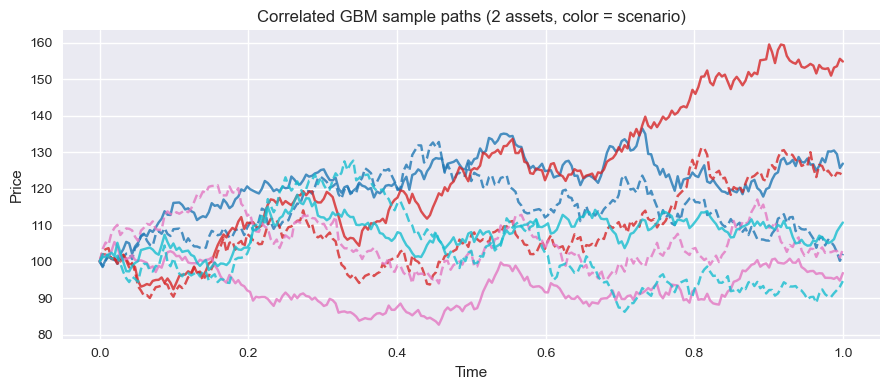

In [33]:
# Plot sample paths for both assets
colors = plt.cm.tab10(np.linspace(0, 1, 4))  # 10 colors

plt.figure(figsize=(9, 4))
for p in range(4):
    c = colors[p]
    plt.plot(t_grid_multi, paths_multi[p, :, 0], color=c, linestyle="-",  alpha=0.8)
    plt.plot(t_grid_multi, paths_multi[p, :, 1], color=c, linestyle="--", alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Correlated GBM sample paths (2 assets, color = scenario)")
plt.tight_layout()
plt.show()


Asset 1:
  Empirical mean: 105.3735, Theoretical mean: 105.1271
  Empirical var : 453.1529, Theoretical var : 451.0288
  Rel. error mean: 0.2344%
  Rel. error var : 0.4710%


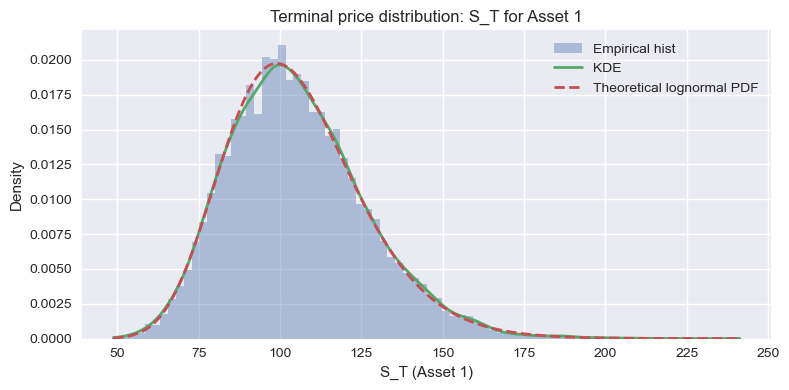

Asset 2:
  Empirical mean: 103.2924, Theoretical mean: 103.0455
  Empirical var : 681.6675, Theoretical var : 684.8257
  Rel. error mean: 0.2396%
  Rel. error var : -0.4612%


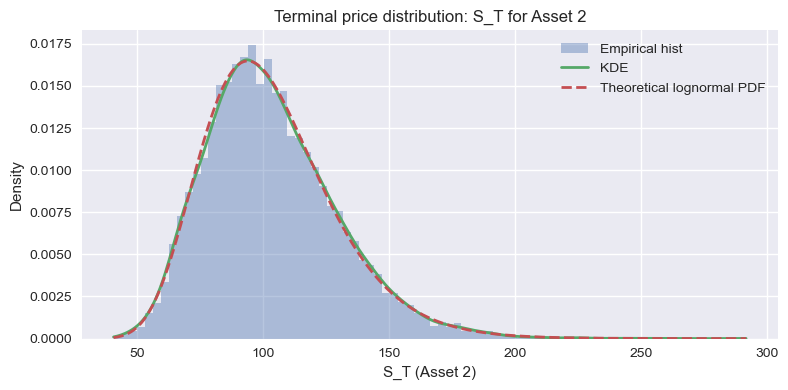

In [25]:
S_T_multi = paths_multi[:, -1, :]  # shape (n_paths, 2)

for i in range(S_T_multi.shape[1]):
    S_T_i = S_T_multi[:, i]
    S0_i = S0_vec[i]
    mu_i = mu_vec[i]
    sigma_i = sigma_vec[i]

    emp_mean_i = S_T_i.mean()
    emp_var_i = S_T_i.var(ddof=1)

    theo_mean_i = S0_i * np.exp(mu_i * T)
    theo_var_i = (S0_i**2) * np.exp(2 * mu_i * T) * (np.exp(sigma_i**2 * T) - 1.0)

    print(f"Asset {i+1}:")
    print(f"  Empirical mean: {emp_mean_i:.4f}, Theoretical mean: {theo_mean_i:.4f}")
    print(f"  Empirical var : {emp_var_i:.4f}, Theoretical var : {theo_var_i:.4f}")
    print(f"  Rel. error mean: {(emp_mean_i - theo_mean_i)/theo_mean_i:.4%}")
    print(f"  Rel. error var : {(emp_var_i - theo_var_i)/theo_var_i:.4%}")

    # Histogram + KDE + theoretical lognormal pdf for S_T of asset i
    plt.figure(figsize=(8, 4))
    count, bins, _ = plt.hist(S_T_i, bins=80, density=True, alpha=0.4, label="Empirical hist")

    # KDE
    kde_i = gaussian_kde(S_T_i)
    x_vals_i = np.linspace(S_T_i.min(), S_T_i.max(), 500)
    plt.plot(x_vals_i, kde_i(x_vals_i), label="KDE", linewidth=2)

    # Theoretical lognormal parameters and pdf
    m_i = np.log(S0_i) + (mu_i - 0.5 * sigma_i**2) * T
    v_i = sigma_i**2 * T
    lognormal_pdf_i = (1 / (x_vals_i * np.sqrt(2 * np.pi * v_i))) * np.exp(
        -((np.log(x_vals_i) - m_i) ** 2) / (2 * v_i)
    )
    plt.plot(x_vals_i, lognormal_pdf_i, label="Theoretical lognormal PDF", linestyle="--", linewidth=2)

    plt.xlabel(f"S_T (Asset {i+1})")
    plt.ylabel("Density")
    plt.title(f"Terminal price distribution: S_T for Asset {i+1}")
    plt.legend()
    plt.tight_layout()
    filename = f"phase2_asset{i+1}_ST_hist_kde_logpdf.png"
    plt.savefig(os.path.join(figures_dir, filename), dpi=150)
    plt.show()


Empirical correlation matrix of terminal simple returns:
[[1.         0.70199247]
 [0.70199247 1.        ]]


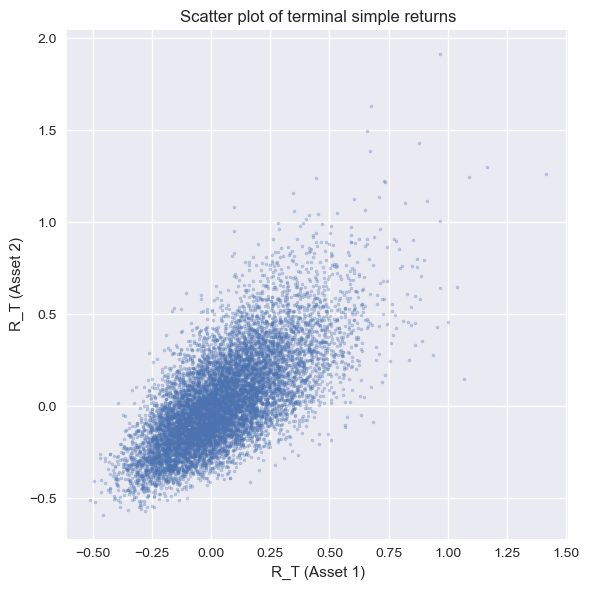

In [27]:
# Simple returns over the whole horizon
R_T_multi = S_T_multi / S0_vec - 1.0  # shape (n_paths, 2)
emp_corr = np.corrcoef(R_T_multi.T)
print("Empirical correlation matrix of terminal simple returns:")
print(emp_corr)

# Scatter plot of terminal simple returns
plt.figure(figsize=(6, 6))
plt.scatter(R_T_multi[:, 0], R_T_multi[:, 1], alpha=0.3, s=5)
plt.xlabel("R_T (Asset 1)")
plt.ylabel("R_T (Asset 2)")
plt.title("Scatter plot of terminal simple returns")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase2_terminal_returns_scatter.png"), dpi=150)
plt.show()
